In [1]:
import boto3
import json
from pprint import pprint
import awswrangler as wr
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

In [2]:
session = boto3.session.Session(profile_name='private', region_name='eu-west-1')

### Map AWS folders

In [12]:
BUCKET = 'groengegeven-swa-v2-export'
FOLDERS = [
    "01739284656378-bd71db43",
    "01739284722624-529e5506",
    "01739284776972-a99a06b6",
    "01739284788050-67e665f3",
    "01739284798614-5b671e7f",
    "01739284811554-85eb6245",
    "01739284823347-49c9effe",
    "01739284835472-8fddc674",
    "01739284847676-a7b7002d",
    "01739284856727-4cfc6f90",
    "01739284863019-70bdd457",
    "01739284884908-ce538ca0",
    "01739284898907-5b08be28",
    "01739284912208-ca44482f",
    "01739284923652-abc2a547",
    "01739284930671-dd126bd3",
    "01739284942073-208066cd",
    "01739284948894-397039ab",
    "01739284955315-3d0b1093",
    "01739284963277-18379b5c",
    "01739284974637-66687335",
    "01739284986083-54ffa187",
    "01739284992734-68731f4d",
    "01739285003296-7fe43df9"
]

In [13]:
s3 = session.client('s3')

In [23]:
folder_map = {}
for folder in FOLDERS:
    response = s3.get_object(Bucket=BUCKET, Key=f'AWSDynamoDB/{folder}/manifest-summary.json')
    manifest = json.loads(response['Body'].read().decode('utf-8'))
    folder_map[manifest['tableArn'].split('/')[-1].split('-')[0]] = folder

In [27]:
pprint(folder_map)

{'Aanvraag': '01739284656378-bd71db43',
 'Apparaat': '01739284722624-529e5506',
 'Apparaten': '01739284776972-a99a06b6',
 'Client': '01739284788050-67e665f3',
 'ClientDisabledFunctionalityLink': '01739284798614-5b671e7f',
 'ClientSupplierLink': '01739284811554-85eb6245',
 'DeletedUser': '01739284823347-49c9effe',
 'DeviceToken': '01739284835472-8fddc674',
 'DisabledFunctionality': '01739284847676-a7b7002d',
 'ExpoToken': '01739284856727-4cfc6f90',
 'HouseGroup': '01739284863019-70bdd457',
 'IsoleerEnMeer': '01739284884908-ce538ca0',
 'Maatregel': '01739284898907-5b08be28',
 'MaatregelSupplier': '01739284912208-ca44482f',
 'Message': '01739284923652-abc2a547',
 'MessageCampaign': '01739284930671-dd126bd3',
 'P4Aggregation': '01739284942073-208066cd',
 'P4Day': '01739284948894-397039ab',
 'P4IntervalMeasurement': '01739284955315-3d0b1093',
 'P4IntervalQueue': '01739284963277-18379b5c',
 'TipsEnKlusjes': '01739284974637-66687335',
 'UsageAggregations': '01739284986083-54ffa187',
 'Woning'

### Query data

In [3]:
clients = {
    "HL - Huurders": "ENn2zWN9smgY2hisWld65HJgn22ung6i", 
    "HL - Kopers": "JYv2oupDzl9BHgZUCEFeV8OPKfjBr3AF", 
    "HL - woCom": "1bc97b4a-45ca-46a2-ac20-937d4c45d03a"
}

In [2]:
p4_agg_query = f"SELECT * FROM swa.p4aggregation where clientid in {tuple(clients.values())} AND aggregationtype in ('month','year')"

NameError: name 'clients' is not defined

In [5]:
df = wr.athena.read_sql_query(
    sql=p4_agg_query,
    database="swa",
    s3_output="s3://gbstraathof-athena-queries/",
    workgroup="primary",
    boto3_session=session,
)

In [27]:
df.to_csv('../data/aws_p4_aggregation.csv', sep=';', index=False)

In [2]:
df = pd.read_csv('../data/aws_p4_aggregation.csv', sep=';')

In [3]:
df.shape

(84970, 28)

In [4]:
columns = ['aggregationtype', 'houseid', 'activationkey', 'date', 'backfeedusage', 'clientid', 'electricityusage', 'gasusage']
subset = df[columns].copy()
subset.sort_values(by=['houseid', 'aggregationtype', 'date'], inplace=True)  # sort

In [5]:
subset['energy'] = subset['electricityusage'] + subset['gasusage'] * 9.77

In [6]:
subset.to_csv('../data/aws_energy.csv', sep=';', decimal=',', index=False)

In [7]:
month = subset[subset['aggregationtype'] == 'month'].copy()
year = subset[subset['aggregationtype'] == 'year'].copy()

In [8]:
month_usage = month.pivot(index='activationkey', columns='date', values='energy')
annual_usage = year.pivot(index='activationkey', columns='date', values='energy')

### 1.4 Energiebesparing

In [9]:
households = pd.read_csv("../data/spa_households.csv", sep=";")
households = households[households['active']]  # Only active
households.rename(columns={'activation_code': 'activationkey'}, inplace=True)
households['inaws'] = households['activationkey'].isin(month['activationkey'].unique())

In [10]:
annual = pd.merge(annual_usage[['2023-01-01', '2024-01-01']], households[['id', 'activationkey', 'date_of_activation']], on='activationkey', how='left')
annual['date_of_activation'] = pd.to_datetime(annual['date_of_activation'], utc=False).dt.tz_localize(None)
print(f"{len(annual)} accounts with annual data")
annual = annual[annual['date_of_activation'] <= datetime(2023, 1, 1)]
print(f"{len(annual)} accounts with annual data activated before 1 January 2023")
annual = annual[(annual['2024-01-01'] > 1) & (annual['2023-01-01'] > 1)]
print(f"{len(annual)} accounts with positive usage figures")

2338 accounts with annual data
1902 accounts with annual data activated before 1 January 2023
1810 accounts with positive usage figures


#### Correct 2024 for missing December figures

In [11]:
annual = pd.merge(annual, month_usage[['2024-11-01']], on='activationkey', how='left')

In [12]:
spa_energy_pivoted = pd.read_csv('../data/spa_energy_pivoted.csv', sep=';', decimal=',')
spa_energy_pivoted.rename(columns={'household_id': 'id'}, inplace=True)

In [13]:
annual = pd.merge(annual, spa_energy_pivoted[['id', '2024-12-01']], on='id', how='left')
print(f"{len(annual)} accounts after merging with monthly data")
annual = annual[~pd.isna(annual['2024-12-01'])]
print(f"{len(annual)} accounts after removing NaN values for december")

1810 accounts after merging with monthly data
1495 accounts after removing NaN values for december


In [14]:
# Add December. The Supabase data do not separate November from December, so I'm extracting November before adding both months.
annual['2023'] = annual['2023-01-01']
annual['2024'] = annual['2024-01-01'] - annual['2024-11-01'] + annual['2024-12-01']

In [15]:
annual = annual[['id', '2023', '2024']].copy()
annual['saving'] = annual['2023'] - annual['2024']
annual = annual[~pd.isna(annual['saving'])]

In [16]:
annual.to_csv('../data/combined_annual_saving.csv', sep=';', decimal=',', index=False)

In [17]:
print(f"Total saving: {(sum(annual['saving']) / sum(annual['2023']))*100:0.1f}%")
print(f"Number of housholds that did save: {(sum(annual['saving'] > 0) / len(annual))*100:.1f}%")
annual['saving_perc'] = annual['saving'] / annual['2023'] * 100
print(f"Their average saving: {annual[annual['saving'] > 0]['saving_perc'].mean():.1f}%")
print(f"Number of housholds that saved > 30%: {(sum(annual['saving_perc'] > 30) / len(annual))*100:.1f}%")

Total saving: -2.9%
Number of housholds that did save: 45.6%
Their average saving: 13.1%
Number of housholds that saved > 30%: 4.6%


In [24]:
print(f"Number of housholds that did save: {sum(annual['saving'] > 0)}/{len(annual)}")
print(f"Number of housholds that saved > 30%: {sum(annual['saving_perc'] > 30)}/{len(annual)}")

Number of housholds that did save: 698/1521
Number of housholds that saved > 30%: 69/1521


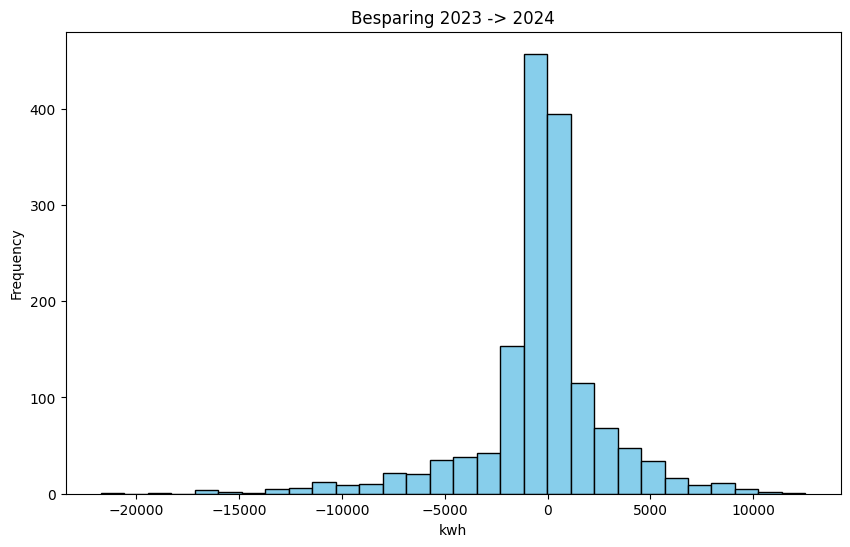

In [22]:
plt.figure(figsize=(10, 6))
plt.hist(annual['saving'], bins=30, color='skyblue', edgecolor='black')
plt.title("Besparing 2023 -> 2024")
plt.xlabel('kwh')
plt.ylabel('Frequency')
plt.show()

### Repeat above for gas alone

In [19]:
monthly_gas_usage = month.pivot(index='activationkey', columns='date', values='gasusage')
annual_gas_usage = year.pivot(index='activationkey', columns='date', values='gasusage')

In [225]:
annual = pd.merge(annual_gas_usage[['2023-01-01', '2024-01-01']], households[['id', 'activationkey', 'date_of_activation', 'heating_type']], on='activationkey', how='left')
annual['date_of_activation'] = pd.to_datetime(annual['date_of_activation'], utc=False).dt.tz_localize(None)
print(f"{len(annual)} accounts with annual data")
annual = annual[annual['date_of_activation'] <= datetime(2023, 1, 1)]
print(f"{len(annual)} accounts with annual data activated before 1 January 2023")
annual = annual[(annual['2024-01-01'] > 1) & (annual['2023-01-01'] > 1)]
print(f"{len(annual)} accounts with positive usage figures")

2338 accounts with annual data
1902 accounts with annual data activated before 1 January 2023
1730 accounts with positive usage figures


In [20]:
annual = pd.merge(annual, monthly_gas_usage[['2024-11-01']], on='activationkey', how='left')

In [21]:
spa_pivoted = pd.read_csv('../data/spa_gas_pivoted.csv', sep=';', decimal=',')
spa_pivoted.rename(columns={'household_id': 'id'}, inplace=True)

In [22]:
annual = pd.merge(annual, spa_pivoted[['id', '2024-12-01']], on='id', how='left')
print(f"{len(annual)} accounts after merging with monthly data")
annual = annual[~pd.isna(annual['2024-12-01'])]
print(f"{len(annual)} accounts after removing NaN values for december")

1758 accounts after merging with monthly data
1644 accounts after removing NaN values for december


In [23]:
# Add December. The Supabase data do not separate November from December, so I'm extracting November before adding both months.
annual['2023'] = annual['2023-01-01']
annual['2024'] = annual['2024-01-01'] - annual['2024-11-01'] + annual['2024-12-01']

In [383]:
annual = annual[['id', '2023', '2024']].copy()
annual['saving'] = annual['2023'] - annual['2024']
annual = annual[~pd.isna(annual['saving'])]

In [384]:
print(f"Total saving: {(sum(annual['saving']) / sum(annual['2023']))*100:0.1f}%")
print(f"Number of housholds that did save: {(sum(annual['saving'] > 0) / len(annual))*100:.1f}%")
annual['saving_perc'] = annual['saving'] / annual['2023'] * 100
print(f"Their average saving: {annual[annual['saving'] > 0]['saving_perc'].mean():.1f}%")
print(f"Number of housholds that saved > 30%: {(sum(annual['saving_perc'] > 30) / len(annual))*100:.1f}%")
print(f"Total consumption in 2023: {sum(annual['2023']):.0f} and 2024: {sum(annual['2024']):.0f}")

Total saving: -0.8%
Number of housholds that did save: 47.9%
Their average saving: 19.2%
Number of housholds that saved > 30%: 12.0%
Total consumption in 2023: 1671675 and 2024: 1685449


### Repeat above for electricity alone

In [20]:
monthly_elec_usage = month.pivot(index='activationkey', columns='date', values='electricityusage')
annual_elec_usage = year.pivot(index='activationkey', columns='date', values='electricityusage')

In [374]:
annual = pd.merge(annual_elec_usage[['2023-01-01', '2024-01-01']], households[['id', 'activationkey', 'date_of_activation']], on='activationkey', how='left')
annual['date_of_activation'] = pd.to_datetime(annual['date_of_activation'], utc=False).dt.tz_localize(None)
print(f"{len(annual)} accounts with annual data")
annual = annual[annual['date_of_activation'] <= datetime(2023, 1, 1)]
print(f"{len(annual)} accounts with annual data activated before 1 January 2023")
annual = annual[(annual['2024-01-01'] > 1) & (annual['2023-01-01'] > 1)]
print(f"{len(annual)} accounts with positive usage figures")

2381 accounts with annual data
1935 accounts with annual data activated before 1 January 2023
1838 accounts with positive usage figures


In [360]:
annual = pd.merge(annual, monthly_elec_usage[['2024-11-01']], on='activationkey', how='left')

In [361]:
spa_pivoted = pd.read_csv('../data/spa_elec_pivoted.csv', sep=';', decimal=',')
spa_pivoted.rename(columns={'household_id': 'id'}, inplace=True)

In [362]:
annual = pd.merge(annual, spa_pivoted[['id', '2024-12-01']], on='id', how='left')
print(f"{len(annual)} accounts after merging with monthly data")
annual = annual[~pd.isna(annual['2024-12-01'])]
print(f"{len(annual)} accounts after removing NaN values for december")

1838 accounts after merging with monthly data
1522 accounts after removing NaN values for december


In [363]:
# Add December. The Supabase data do not separate November from December, so I'm extracting November before adding both months.
annual['2023'] = annual['2023-01-01']
annual['2024'] = annual['2024-01-01'] - annual['2024-11-01'] + annual['2024-12-01']

In [364]:
annual = annual[['id', '2023', '2024']].copy()
annual['saving'] = annual['2023'] - annual['2024']
annual = annual[~pd.isna(annual['saving'])]

In [365]:
print(f"Total saving: {(sum(annual['saving']) / sum(annual['2023']))*100:0.1f}%")
print(f"Number of housholds that did save: {(sum(annual['saving'] > 0) / len(annual))*100:.1f}%")
annual['saving_perc'] = annual['saving'] / annual['2023'] * 100
print(f"Their average saving: {annual[annual['saving'] > 0]['saving_perc'].mean():.1f}%")
print(f"Number of housholds that saved > 30%: {(sum(annual['saving_perc'] > 30) / len(annual))*100:.1f}%")
print(f"Total consumption in 2023: {sum(annual['2023']):.0f} and 2024: {sum(annual['2024']):.0f}")

Total saving: -9.3%
Number of housholds that did save: 38.0%
Their average saving: 10.3%
Number of housholds that saved > 30%: 2.6%
Total consumption in 2023: 5268959 and 2024: 5757929


### Hybrid heating

In [43]:
gas_summer = pd.merge(monthly_gas_usage[['2024-07-01']].copy(), households[['activationkey', 'date_of_activation', 'heating_type', 'gas_ean', 'zipcode', 'id']], on='activationkey', how='left')
gas_summer.rename(columns={'2024-07-01': 'g_summer'}, inplace=True)
summer = pd.merge(gas_summer, monthly_elec_usage[['2024-07-01']], on='activationkey')
summer.rename(columns={'2024-07-01': 'e_summer'}, inplace=True)

df = summer.groupby('activationkey').agg('last') # remove duplicate activationkeys found in households
df = df.reset_index()

# Adding winter electric usage
spa_pivoted = pd.read_csv('../data/spa_elec_pivoted.csv', sep=';', decimal=',')
spa_pivoted.rename(columns={'household_id': 'id'}, inplace=True)
df = pd.merge(df, spa_pivoted[['id', '2025-01-01']], on='id', how='left')
df.rename(columns={'2025-01-01': 'e_winter'}, inplace=True)

# Adding winter gas usage
spa_pivoted = pd.read_csv('../data/spa_gas_pivoted.csv', sep=';', decimal=',')
spa_pivoted.rename(columns={'household_id': 'id'}, inplace=True)
df = pd.merge(df, spa_pivoted[['id', '2025-01-01']], on='id', how='left')
df.rename(columns={'2025-01-01': 'g_winter'}, inplace=True)


df['date_of_activation'] = pd.to_datetime(df['date_of_activation'], utc=False).dt.tz_localize(None)
print(f"{len(df)} accounts with monthly data")
df = df[df['date_of_activation'] <= datetime(2024, 7, 1)]
print(f"{len(df)} accounts with df data activated before 1 July 2024")
df = df[(df['e_summer'] > 0) & (df['e_winter'] > 0)]
print(f"{len(df)} accounts with positive usage figures")
df = df[~pd.isna(df['gas_ean'])]
print(f"{len(df)} accounts with a gas EAN")

2338 accounts with monthly data
2121 accounts with df data activated before 1 July 2024
1884 accounts with positive usage figures
1774 accounts with a gas EAN


#### OLD => using incomplete november figures

#### <= OLD

In [44]:
translations = {
    'Central heating boiler, Heat pump': 'Hybride', 
    'Heat pump': 'Warmtepomp', 
    'Heat pump, Central heating boiler': 'Hybride',
    'Heat pump, Underfloor heating': 'Warmtempomp',
    'Heat pump, Underfloor heating, Central heating boiler': 'Hybride',
    'Hybrid boiler': 'Hybride',
    'Hybrid boiler, Underfloor heating': 'Hybride',
    'Hybrid heat pump': 'Hybride',
    'Hybrid heat pump, Underfloor heating, Infrared panels': 'Hybride',
    'Hybride ketel': 'Hybride',
}
translations.update({'': None})

df['heating_type'] = df['heating_type'].replace(translations)

In [59]:
# Predict
df['hybride'] = (df['e_winter'] > 300) & (df['g_winter'] < 30)
df.groupby('zipcode')['hybride'].agg(['count', 'sum']).to_csv('../data/hybride_prediction_zip6.csv')

In [34]:
# Only select 'Hybride' 'Warmtepomp' 'CV Ketel' for the test
for_analysis = df[df['heating_type'].isin(['Hybride', 'Warmtepomp', 'CV Ketel'])]
for_analysis = for_analysis[['g_summer', 'g_winter', 'e_summer', 'e_winter', 'heating_type']]

# Remove 'CV Ketel' with 0 gas usage in Nov
for_analysis = for_analysis[~((for_analysis['g_winter'] == 0) & (for_analysis['heating_type'] == 'CV Ketel'))]

In [184]:
for_analysis.to_csv('../data/energy_usage_by_heating_type.csv', index=False)

In [ ]:
# Apply the simplified rule: "winter gas usage < 30 AND winter electricity > 300"
def simple_rule(row):
    if row['g_winter'] < 30 and row['e_winter'] > 300:
        return "Warmtepomp/Hybride"
    else:
        return "CV Ketel"

df['predicted_type'] = df.apply(simple_rule, axis=1)

# Calculate accuracy of the simplified rule
accuracy = (
    ((df['predicted_type'] == "Warmtepomp/Hybride") & ((df['heating_type'] == "Warmtepomp") | (df['heating_type'] == "Hybride"))) |
    ((df['predicted_type'] == "CV Ketel") & (df['heating_type'] == "CV Ketel"))
).mean()

print(f"Simplified rule accuracy: {accuracy:.4f}")

# Create confusion matrix
print("\nConfusion matrix:")
confusion = pd.crosstab(df['heating_type'], df['predicted_type'], 
                        rownames=['Actual'], colnames=['Predicted'])
print(confusion)

# Calculate precision and recall for each class
print("\nPerformance metrics:")
for heating_type in ["CV Ketel", "Hybride", "Warmtepomp"]:
    if heating_type == "CV Ketel":
        true_pos = ((df['heating_type'] == heating_type) & (df['predicted_type'] == heating_type)).sum()
        false_pos = ((df['heating_type'] != heating_type) & (df['predicted_type'] == heating_type)).sum()
        false_neg = ((df['heating_type'] == heating_type) & (df['predicted_type'] != heating_type)).sum()
    else:
        true_pos = ((df['heating_type'] == heating_type) & (df['predicted_type'] == "Warmtepomp/Hybride")).sum()
        false_pos = ((df['heating_type'] == "CV Ketel") & (df['predicted_type'] == "Warmtepomp/Hybride")).sum() / 2  # Split false positives between Hybride and Warmtepomp
        false_neg = ((df['heating_type'] == heating_type) & (df['predicted_type'] == "CV Ketel")).sum()
    
    precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
    recall = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"{heating_type}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")

# Create visualization: Winter gas usage vs Winter electricity
plt.figure(figsize=(12, 8))

# Create a scatter plot with color-coded points by heating type
for heating_type, color in zip(['CV Ketel', 'Hybride', 'Warmtepomp'], ['blue', 'green', 'red']):
    subset = df[df['heating_type'] == heating_type]
    plt.scatter(subset['g_winter'], subset['e_winter'], 
                label=heating_type, 
                color=color, 
                alpha=0.7)

# Add a horizontal line at e_winter = 300
plt.axhline(y=300, color='gray', linestyle='--', alpha=0.7)

# Add a vertical line at g_winter = 30
plt.axvline(x=30, color='gray', linestyle='--', alpha=0.7)

# Shade the region where the rule applies
plt.fill_between([0, 30], 300, 1200, color='yellow', alpha=0.2)

# Add labels and title
plt.xlabel('Winter Gas Usage', fontsize=12)
plt.ylabel('Winter Electricity Usage', fontsize=12)
plt.title('Winter Gas vs Electricity Usage by Heating Type', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Add text to indicate the rule region
# plt.text(15, 800, "Rule Region:\ng_winter < 30 AND e_winter > 300", 
#          fontsize=12, ha='center', bbox=dict(facecolor='white', alpha=0.7))

# Adjust axis limits for better visualization
plt.xlim(-5, 250)
plt.ylim(0, 1000)

plt.savefig('winter_energy_distribution.png')

# Create a zoomed-in version focusing on the rule region
plt.figure(figsize=(12, 8))

for heating_type, color in zip(['CV Ketel', 'Hybride', 'Warmtepomp'], ['blue', 'green', 'red']):
    subset = df[df['heating_type'] == heating_type]
    plt.scatter(subset['g_winter'], subset['e_winter'], 
                label=heating_type, 
                # color=color, 
                alpha=0.7)

plt.axhline(y=300, color='gray', linestyle='--', alpha=0.7)
plt.axvline(x=30, color='gray', linestyle='--', alpha=0.7)
plt.fill_between([0, 30], 300, 1000, color='yellow', alpha=0.2)

plt.xlabel('Winter Gas Usage (g_winter)', fontsize=12)
plt.ylabel('Winter Electricity Usage (e_winter)', fontsize=12)
plt.title('Winter Gas vs Electricity Usage (Zoomed to Rule Region)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# plt.text(15, 800, "Rule Region:\ng_winter < 30 AND e_winter > 300", 
#          fontsize=12, ha='center', bbox=dict(facecolor='white', alpha=0.7))

plt.xlim(-5, 100)
plt.ylim(0, 1000)

plt.savefig('winter_energy_distribution_zoomed.png')

# Count how many of each heating type fall within the rule region
rule_region = df[(df['g_winter'] < 30) & (df['e_winter'] > 300)]
print("\nHeating types in rule region (g_winter < 30 AND e_winter > 300):")
print(rule_region['heating_type'].value_counts())

# Calculate what percentage of each heating type falls within the rule region
print("\nPercentage of each heating type in rule region:")
for heating_type in ['CV Ketel', 'Hybride', 'Warmtepomp']:
    total = df[df['heating_type'] == heating_type].shape[0]
    in_region = rule_region[rule_region['heating_type'] == heating_type].shape[0]
    percentage = (in_region / total) * 100 if total > 0 else 0
    print(f"{heating_type}: {percentage:.2f}% ({in_region}/{total})")

#### Plot typical patterns

In [32]:
df['predicted_type'] = df.apply(simple_rule, axis=1)

In [209]:
# Reduce to extreme quadrants
df = df[~((df['predicted_type'] == 'CV Ketel') & (df['g_winter'] < 30))]
df = df[~((df['predicted_type'] == 'CV Ketel') & (df['e_winter'] > 300))]

In [210]:
year = '2023'
columns = monthly_elec_usage.columns[monthly_elec_usage.columns.str.contains(year)]
type_vs_elec = pd.merge(df[['activationkey', 'predicted_type']], monthly_elec_usage[columns], on='activationkey', how='left')
type_vs_elec.drop(columns='activationkey', inplace=True)
type_vs_gas = pd.merge(df[['activationkey', 'predicted_type']], monthly_gas_usage[columns], on='activationkey', how='left')
type_vs_gas.drop(columns='activationkey', inplace=True)

In [211]:
type_vs_elec.to_csv(f'../data/type_vs_elec_{year}.csv', index=False)
type_vs_gas.to_csv(f'../data/type_vs_gas_{year}.csv', index=False)

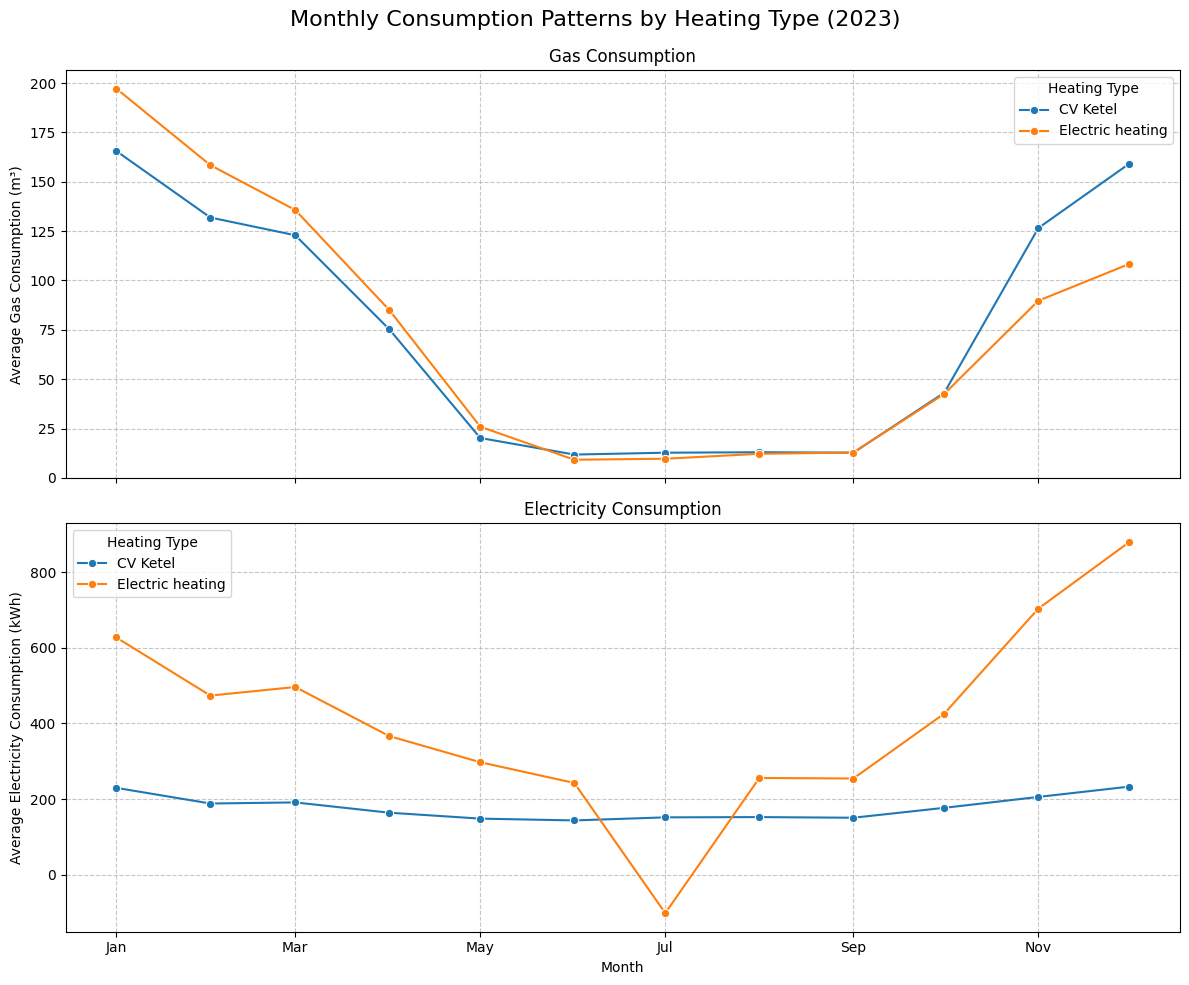

Number of households by heating type:
predicted_type
CV Ketel            145
Electric heating     31
Name: count, dtype: int64

Average annual gas consumption by heating type:
predicted_type
CV Ketel            10698.689833
Electric heating     2291.499583
dtype: float64

Average annual electricity consumption by heating type:
predicted_type
CV Ketel            25513.485500
Electric heating    12710.685333
dtype: float64


In [212]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Load the data
# type_vs_gas = pd.read_csv('type_vs_gas_2023.csv')
# type_vs_elec = pd.read_csv('type_vs_elec_2023.csv')

# Rename 'Hybride' and 'Warmtepomp' to 'Electric heating'
type_vs_gas['predicted_type'] = type_vs_gas['predicted_type'].replace({'Warmtepomp/Hybride': 'Electric heating'})
type_vs_elec['predicted_type'] = type_vs_elec['predicted_type'].replace({'Warmtepomp/Hybride': 'Electric heating'})

# Get the month columns (excluding 'activationkey' and 'predicted_type')
month_columns = [col for col in type_vs_gas.columns if col not in ['activationkey', 'predicted_type']]

# Function to calculate average consumption by type and month
def calculate_avg_by_type(df):
    # Group by predicted_type and calculate mean for each month
    avg_by_type = df.groupby('predicted_type')[month_columns].mean()
    
    # Convert to long format for easier plotting
    avg_by_type_long = avg_by_type.reset_index().melt(
        id_vars=['predicted_type'],
        value_vars=month_columns,
        var_name='month',
        value_name='consumption'
    )
    
    # Convert month strings to datetime for proper ordering
    avg_by_type_long['month'] = pd.to_datetime(avg_by_type_long['month'])
    
    return avg_by_type_long

# Calculate average consumption by type for gas and electricity
gas_avg_by_type = calculate_avg_by_type(type_vs_gas)
elec_avg_by_type = calculate_avg_by_type(type_vs_elec)

# Set up the figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
fig.suptitle(f'Monthly Consumption Patterns by Heating Type ({year})', fontsize=16)

# Plot gas consumption
sns.lineplot(
    data=gas_avg_by_type, 
    x='month', 
    y='consumption', 
    hue='predicted_type',
    marker='o',
    ax=ax1
)
ax1.set_title('Gas Consumption')
ax1.set_ylabel('Average Gas Consumption (m³)')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend(title='Heating Type')

# Plot electricity consumption
sns.lineplot(
    data=elec_avg_by_type, 
    x='month', 
    y='consumption', 
    hue='predicted_type',
    marker='o',
    ax=ax2
)
ax2.set_title('Electricity Consumption')
ax2.set_ylabel('Average Electricity Consumption (kWh)')
ax2.set_xlabel('Month')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend(title='Heating Type')

# Format x-axis to show month names
import matplotlib.dates as mdates
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)

# Save the figure
plt.savefig(f'consumption_patterns_{year}.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# Print some statistics
print("Number of households by heating type:")
print(type_vs_gas['predicted_type'].value_counts())

print("\nAverage annual gas consumption by heating type:")
gas_annual = type_vs_gas.groupby('predicted_type')[month_columns].sum(numeric_only=True).mean(axis=1)
print(gas_annual)

print("\nAverage annual electricity consumption by heating type:")
elec_annual = type_vs_elec.groupby('predicted_type')[month_columns].sum(numeric_only=True).mean(axis=1)
print(elec_annual)

#### Plot ratios

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


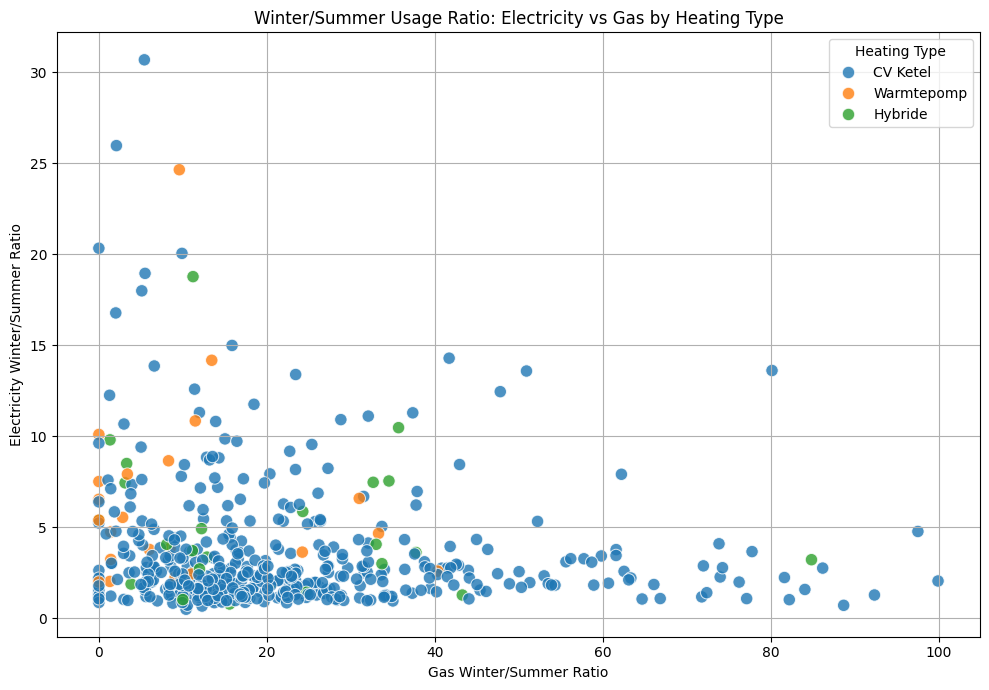

In [206]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df['gas_ratio'] = df['g_winter'] / (df['g_summer'] + 1e-6)
df['elec_ratio'] = df['e_winter'] / (df['e_summer'] + 1e-6)

df = df[df['gas_ratio'] < 100]


plt.figure(figsize=(10,7))
sns.scatterplot(
    x='gas_ratio', y='elec_ratio', hue='heating_type', data=df, s=80, alpha=0.8
)
plt.xlabel('Gas Winter/Summer Ratio')
plt.ylabel('Electricity Winter/Summer Ratio')
plt.title('Winter/Summer Usage Ratio: Electricity vs Gas by Heating Type')
plt.legend(title='Heating Type')
plt.grid(True)
plt.tight_layout()
plt.show()

In [205]:
df.groupby('heating_type').agg('count')

,activationkey,g_summer,date_of_activation,gas_ean,zipcode,id,e_summer,e_winter,g_winter,hybride,gas_ratio,elec_ratio
heating_type,,,,,,,,,,,,
CV Ketel,462,462,462,462,462,462,462,462,462,462,462,462
Hybride,24,24,24,24,24,24,24,24,24,24,24,24
Warmtepomp,22,22,22,22,22,22,22,22,22,22,22,22


## 16 june : electric heating AND electric cooking

In [68]:
cooking = pd.read_csv('../data/cooking_predictions.csv')

In [69]:
heating_cooking = pd.merge(df, cooking[['activationkey', 'prediction', 'probability']], on='activationkey', how='left')
heating_cooking['postcode'] = heating_cooking['zipcode'].apply(lambda x: x[:4])

In [77]:
heating_cooking['induction'] = (heating_cooking['prediction'] == 'induction') & (heating_cooking['probability'] > 0.95)
heating_cooking['both'] = heating_cooking['hybride'] & heating_cooking['induction']
heating_cooking.to_csv('../data/heating_cooking.csv', index=False)

In [73]:
heating_cooking.groupby('postcode')[['hybride','induction','both']].agg(['count', 'sum'])

hybride     induction      both    
           count sum     count sum count sum
postcode                                    
5591        1162  61      1162  64  1162   5
5595         468  26       468  46   468   3
6029         144   9       144  13   144   0